In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy as sp

In [2]:
x = np.arange(4)
x = x.repeat(4).reshape((4,4))
vol = np.zeros((4,4,4))
for i in range( vol.shape[0]):
    vol[:,i,:] = x
    
inds = np.arange(4**3).reshape((4,4,4))

In [472]:
import random
def fill_below(fault):
    new = np.zeros_like(fault)
    inds = np.where(fault > 0)
    for i in range(new.shape[0]):
        new[inds[0][i],:inds[1][i]] = 1
    return new
def fill_above(fault):
    new = np.zeros_like(fault)
    inds = np.where(fault > 0)
    for i in range(new.shape[0]):
        new[inds[0][i],inds[1][i]:] = 1
    return new
class Fault:
    def __init__(self,x,y,age,throw):
        
        self.x = x
        self.y = y
        self.dim = tuple( (len(x),len(y)) ) 
        self.age = age
        self.throw = throw
        self.view = np.zeros(self.dim)
        self.view[self.x,self.y] = 1
        
import scipy as sp
from scipy import ndimage

def fault_mania(view,num_faults,throw,spacing='same'):
    sx,sy = view.shape
    faults = []
    x = np.arange(sx)
    shifts = np.arange(0,sx,sx//num_faults)
    
    f_prev = np.zeros((sx,sx))
    for i,sh in enumerate(shifts):
        if sh == 0:
            sh = 10
        y = (np.arange(sx) // int(random.uniform(1,8))) + sh
        f_current = np.zeros((sx,sx))
        print(max(y))
        try:
            f_current[x,y] = 1
        except:
            print('fault out of bound')
            continue
            
        th = sp.ndimage.interpolation.shift(view,(throw,0),cval=0)
        new = fill_below(f_current)*view + th*fill_above(f_current)
        
        
        f_current[:throw,:] = 0

        faults.append(Fault(x,y,i,throw))
            
        throw += throw
        view = new
        f_prev = f_current
        
        
        return view,faults
    



In [4]:
f = np.fromfile(r"C:\Users\adelv\Downloads\195.dat",dtype=np.single)
f = f.reshape(128,128,128)

np.save(r'C:\Users\adelv\Documents\testdat\reformatted_195.npy',f)



In [1514]:
def ricker(f, length=0.512, dt=0.01):
    t = np.linspace(-length/2, (length-dt)/2, int(length/dt))
    y = (1.-2.*(np.pi**2)*(f**2)*(t**2))*np.exp(-(np.pi**2)*(f**2)*(t**2))
    return t, y



def convolve_volume(volume,wavelet):
    new_volume = np.zeros_like(volume)
    for iline in range(volume.shape[0]):
        temp = np.apply_along_axis(lambda slice: np.convolve(slice,wavelet,mode='same'),arr=volume[:,iline,:],axis=0)
        new_volume[:,iline,:] = temp
    return new_volume


def shift_volume_down(volume,amount):
    shifted = sp.ndimage.interpolation.shift(volume,(amount,0,0),cval=0,prefilter=False,order=1)
    return shifted

def new_fill_above(faultview):
    new = np.zeros_like(faultview)
    for i,row in enumerate(faultview):
        try:
            ind = np.where(row == 1)[0][0]
            new[i,ind:] = 1
        except:
            continue
    return new

def new_fill_below(faultview):
    new = np.zeros_like(faultview)
    for i,row in enumerate(faultview):
        try:
            ind = np.where(row == 1)[0][0]
            new[i,:ind] = 1
        except:
            new[i,:] = 1
    return new

#rerender the cube with z-axis as the third element
def order_lines(input_volume):
    new_vol = np.zeros(input_volume.shape)
    for z in range(new_vol.shape[2]):
        new_vol[:,:,z] = input_volume[z,:,:]
    return new_vol


def stich_volumes(volume,shifted_volume,above,below):
    return volume*below + shifted_volume*above


def generate_strikes(dim,num_faults,add_cross_cutting=False):
    
    location_list = []
    strikes = []
    x = np.arange(dim)
    dip = np.random.randint(3,8)
    
    
    while len(location_list) < num_faults:
        
        location = np.random.randint(1,dim//20) * 20
        
        if location not in location_list:
            y = x // dip + location
            location_list.append(location)
            strikes.append(y)
            
    if add_cross_cutting == True:
        location = 0
        y = x // 1 + location
        location_list.append(location)
        strikes.append(y)
        
    
    return strikes
            
            
            
#create fault, clips fault if out of bound
def create_fault(dim, dip, location):
    view = np.zeros((dim,dim))
    x = np.arange(dim)
    y = x // dip + location
    
    if y.max() >= dim:
        val = np.where(y >= dim)[0].min() 
        x = x[:val]; y = y[:val]
        
    view[x,y] = 1
    return view

def generate_fault_volume(dim,sx,sy):
    fault = create_fault(dim,2,0)
    fault_start = sy.min()

    faultvol = np.zeros((dim,dim,dim))
    above = np.zeros((dim,dim,dim))
    below = np.zeros((dim,dim,dim))
    for iline in range(sx.min(),sx.max()):
        try:
            faultvol[:,iline,:] = create_fault(dim,2,sy[iline])#sp.ndimage.interpolation.shift(fault,(0,sy[i]),cval=0,prefilter=False,order=1)
            above[:,iline,:] = new_fill_above(faultvol[:,iline,:])
            below[:,iline,:] = new_fill_below(faultvol[:,iline,:])
        except:
            continue
    return faultvol,above,below    


def normalize(function):
    return (function - function.min() ) / (function.max()- function.min())

def normalize_with_max(function,maxval):
    return (function - function.min() ) / (maxval - function.min())

def smooth_series(dim,length,mu,sigma,noise2d):
    return (np.convolve(g(np.linspace(-dim/length,dim/length),mu,sigma),
                 noise2d[:,np.random.randint(noise2d.shape[0])]*100,mode='same'))




def fault_from_fill(filled_view):
    x = []
    y = []
    for i in range(filled_view.shape[0]):
        try:
            xx = i
            yy = np.where(filled_view[i,:] == 1)[0].min()
            x.append(xx)
            y.append(yy)
        except:
            continue
    
    fview = np.zeros(filled_view.shape)
    fview[x,y] = 1
    return fview

def clip_within_bounds(dim,yvals):
    x,y = 0,0
    if yvals.max() >= dim:
        try:
            val = np.where(yvals >= dim)[0].min()
            y = yvals[:val]
            x = np.arange(dim)[:val]
        except:
            print('error')
    else:
        x = np.arange(dim)
        y = yvals

    return x,y

def listric_fault(dim,depth_horizontal = 1.1, start_location = 0, mode = 'return_values'):
    if depth_horizontal <= 1:
        depth_horizontal =1.1
    if start_location > dim:
        start_location = dim
    
    x = np.arange(dim)
    y = (x**2 / (depth_horizontal*dim - x))
    y = ((normalize_with_max(y,dim)) * dim + start_location).astype(int)
    
    xx,yy = clip_within_bounds(dim,y)
    
    view = np.zeros((dim,dim))
    view[xx,yy] = 1
    view = new_fill_above(view)
    
    if mode == 'return_values':
        fault = fault_from_fill(view)
        xx,yy = np.where(fault == 1)
        return xx,yy
    else:
        return fault_from_fill(view)
    
def deg_to_rad(deg):
    return (np.pi/180)*deg

def normal_fault(dim, dip, start_location = 0, return_values=True):

    
    x = np.arange(dim)
    y = x * np.cos(deg_to_rad(dip))
    y = ((normalize_with_max(y,dim)) * dim + start_location).astype(int)
    
    xx,yy = clip_within_bounds(dim,y)
    
    view = np.zeros((dim,dim))
    view[xx,yy] = 1
    view = new_fill_above(view)
    print(view.shape)
    
    if return_values == True:
        fault = fault_from_fill(view)
        xx,yy = np.where(fault == 1)
        return xx,yy
    else:
        return fault_from_fill(view)
    
    
def normal_fault(dim, dip, start_location = 0, return_values=True):
    
    x = np.arange(dim)
    y = x * np.cos(deg_to_rad(dip))
    y = ((normalize_with_max(y,dim)) * dim + start_location).astype(int)
    
    xx,yy = clip_within_bounds(dim,y)
    
    view = np.zeros((dim,dim))
    view[xx,yy] = 1
    view = new_fill_above(view)
    print(view.shape)
    
    if return_values == True:
        fault = fault_from_fill(view)
        xx,yy = np.where(fault == 1)
        return xx,yy
    else:
        return fault_from_fill(view)
    
    
def format_strikes(strikes):
    view = np.zeros((dim,dim))
    strikes_x = []
    strikes_y = []
    for s in strikes:
        if s.max() >= dim:
            try:
                val = np.where(s >= dim)[0].min() 
                view[np.arange(dim)[:val], s[:val]] = 1
                strikes_y.append(s[:val])
                strikes_x.append(np.arange(dim)[:val])
            except:
                print("--noe-rart--")
                print((s[:val-1]))
                print(np.arange(dim)[:val-1])
                continue
        else:
            try:
                view[np.arange(dim),s] = 1
                strikes_x.append(np.arange(dim))
                strikes_y.append(s)
            except:
                print('--out-of-bound--')
                continue
    return strikes_x, strikes_y,view

def partial_fill_above(faultview,depth=100000):
    
    new = np.zeros_like(faultview)
    
    for i,row in enumerate(faultview):
        if i < depth:
            try:
                ind = np.where(row == 1)[0][0]
                new[i,ind:] = 1
            except:
                continue
    return new

def partial_fill_below(faultview,depth=100000):
    new = np.zeros_like(faultview)
    for i,row in enumerate(faultview):
        if i < depth:
            try:
                ind = np.where(row == 1)[0][0]
                new[i,:ind] = 1
            except:
                new[i,:] = 1
        else:
            try:
                ind = np.where(row == 1)[0][0]
                new[i,:] = 1
            except:
                new[i,:] = 1
            
    return new

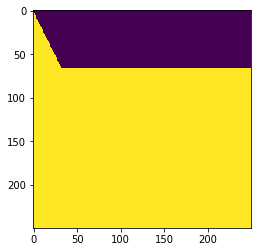

In [1510]:
tx = np.arange(dim)
ty = tx //2
ff = np.zeros((dim,dim))
ff[tx,ty] = 1
plt.imshow(partial_fill_below(ff,66))

In [1332]:
from opensimplex import OpenSimplex

dim = 250
out = 128
dz_top = (dim - out)//2
dz_base = dim - dz_top

throw = 10

import numpy as np
import matplotlib.pyplot as plt


#refl = 2 * np.random.random_sample(dim) - 1 
refl = np.random.normal(0,4,size=(dim))
refls = refl.repeat(dim).reshape((dim,dim))
seismic = np.zeros((dim,dim,dim))



g = lambda x,mu,sigma: 1/(np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x-mu)**2/(2*sigma**2))

# tmp = OpenSimplex((np.random.randint(100)))
val = np.zeros((dim,dim))
for i in range(dim):
    for j in range(dim):
        val[i,j] = tmp.noise2d(i,j)**2



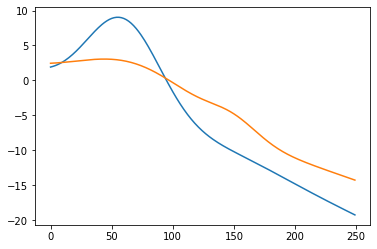

In [1350]:
a =  10*g(np.arange(dim),60,30)  + g(np.arange(dim),150,40)  + 2*g(np.arange(dim),200,100)  
b = 8*g(np.arange(dim),70,50) + g(np.arange(dim),150,20)  + 2*g(np.arange(dim),250,110) 
newlin = -15 * normalize(lin)
newlin2 = -20 * normalize(lin)
b = b * 100 + newlin
a = a * 100 + newlin2
plt.plot(a)
plt.plot(b)

In [1515]:

lin = np.arange(dim)
    
newlin = -10 * normalize(lin)
newlin2 = -5 * normalize(lin)

shifts = a #smooth_series(dim,18,0,8,val) + newlin 
shifts2 = b #smooth_series(dim,18,0,8,val) + newlin2

newvol = np.zeros((dim,dim,dim))
for iline in range(newvol.shape[0]):
    newvol[:,iline,:] = refls
    
#t,y = ricker(20)

for iline in range(refls.shape[1]):
    temp = sp.ndimage.interpolation.shift(newvol[:,iline,:],(-shifts2[iline],0),cval=0)
    newvol[:,iline,:] = temp
    #newvol[:,iline,:] = np.apply_along_axis(lambda t: np.convolve(t,y,mode='same'),arr=temp,axis=0)

for xline in range(newvol.shape[2]):
    temp = sp.ndimage.interpolation.shift(newvol[:,:,xline],(-shifts[xline],0),cval=0)
    newvol[:,:,xline] = temp
    
    #newvol[:,:,xline] = np.apply_along_axis(lambda t: np.convolve(t,y,mode='same'),arr=temp,axis=0)


In [1585]:
strikes_x = []
strikes_y = []

'''
locs_listric = [10]
depth_H = [0]


for i in range(len(locs_listric)): 

    x,y = listric_fault(dim,depth_H[i],locs_listric[i])
    strikes_x.append(x)
    strikes_y.append(y)
    
'''    
locs_normal = [10,40,60]
dips = [50,60,50]

for i in range(len(locs_normal)): 
    x,y = normal_fault(dim,dips[i],locs_normal[i])
    strikes_x.append(x)
    strikes_y.append(y)
    


(250, 250)
(250, 250)
(250, 250)


In [1586]:
#elliptic strike
ty = g(np.arange(dim),100,80) * 4000 
ty = ty.astype(int)

209


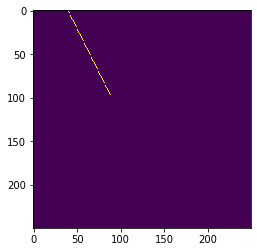

189


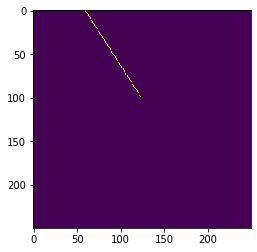

In [1594]:
ind = 0

f = np.zeros((dim,dim))

maxshift = dim - strikes_y[ind].min() - 1



sy = (normalize(np.arange(dim))*np.random.randint(10,maxshift)).astype(int) 


f[strikes_x[ind],strikes_y[ind]] = 1


above = np.zeros((dim,dim,dim))
below = np.zeros((dim,dim,dim))
tvol = np.zeros((dim,dim,dim))

for i in range(dim):
    tvol[:,i,:] = sp.ndimage.interpolation.shift(f,(0,sy[i]),cval=0,prefilter=False,order=1)
    above[:,i,:] = new_fill_above(tvol[:,i,:])
    below[:,i,:] = new_fill_below(tvol[:,i,:])
    
    
seisvol = stich_volumes(newvol,shift_volume_down(newvol,throw),above,below)


for ind in range(1,len(strikes_x)):

    f = np.zeros((dim,dim))

    maxshift = dim - strikes_y[ind].min() - 1
    print(maxshift)

    sy = (normalize(np.arange(dim))*np.random.randint(10,maxshift)).astype(int) 
    
    
    f[strikes_x[ind],strikes_y[ind]] = 1
    f = partial_fill_above(f,100)*f


    above2 = np.zeros((dim,dim,dim))
    below2 = np.zeros((dim,dim,dim))
    tvol2 = np.zeros((dim,dim,dim))
    
    
    #shift the strike of the fault (ty)
    for i in range(dim):
        tvol2[:,i,:] = sp.ndimage.interpolation.shift(f,(0,sy[i]),cval=0,prefilter=False,order=1)
        above2[:,i,:] = partial_fill_above(tvol2[:,i,:],100)
        below2[:,i,:] = partial_fill_below(tvol2[:,i,:],100)
    
    plt.imshow(below2[:,0,:])
    plt.imshow(tvol2[:,0,:])
    plt.show()
    seisvol = stich_volumes(seisvol,shift_volume_down(seisvol,throw),above2,below2)   
    tvol = stich_volumes(tvol,shift_volume_down(tvol,throw),above2,below2)
    tvol = tvol + tvol2

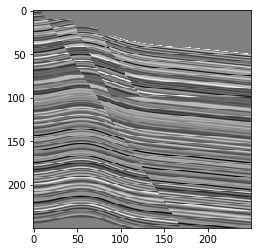

In [1595]:
plt.imshow(seisvol[:,0,:],cmap='gray')

In [1596]:
def ricker(f, length=.5/2, dt=0.001):
    t = np.linspace(-length/2, (length-dt)/2, int(length/dt))
    y = (1.-2.*(np.pi**2)*(f**2)*(t**2))*np.exp(-(np.pi**2)*(f**2)*(t**2))
    return t, y

t,y = ricker(200)


In [1597]:


faultvol = tvol.copy()
finalvol = seisvol.copy()

for iline in range(refls.shape[1]):
    #temp = sp.ndimage.interpolation.shift(newvol[:,iline,:],(shifts2[iline],0),cval=0)
    finalvol[:,iline,:] = np.apply_along_axis(lambda t: np.convolve(t,y,mode='same'),arr=finalvol[:,iline,:],axis=0)

for xline in range(newvol.shape[2]):
    #temp = sp.ndimage.interpolation.shift(newvol[:,:,xline],(shifts[xline],0),cval=0)
    finalvol[:,:,xline] = np.apply_along_axis(lambda t: np.convolve(t,y,mode='same'),arr=finalvol[:,:,xline],axis=0)

In [1598]:
finalnoise = finalvol.copy()
for iline in range(refls.shape[1]):
    temp = sp.ndimage.gaussian_filter(finalnoise[:,iline,:], sigma=1.5)
    finalnoise[:,iline,:] = temp + .7*temp.std() * np.random.random(temp.shape)

    
for xline in range(newvol.shape[2]):
    temp = sp.ndimage.gaussian_filter(finalnoise[:,:,xline], sigma=1.5)
    finalnoise[:,:,xline] = temp + .7*temp.std() * np.random.random(temp.shape)
    




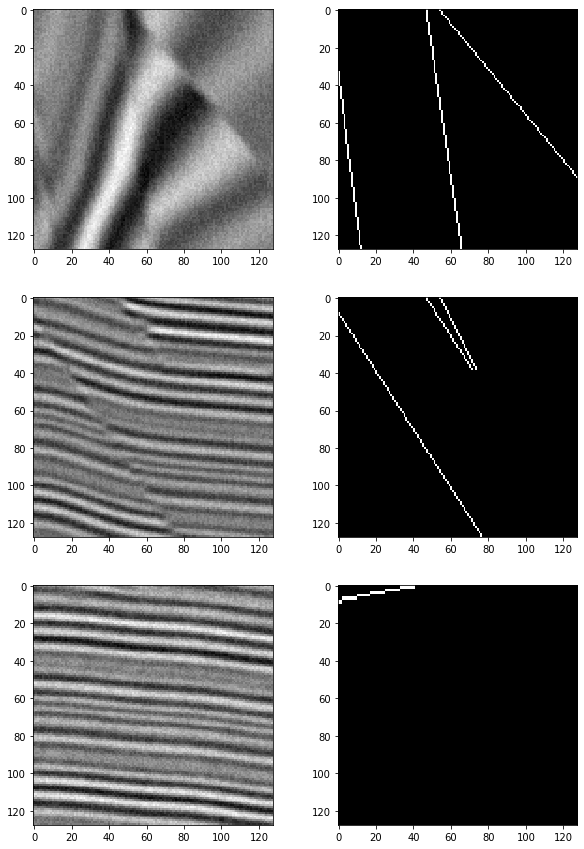

In [1599]:

fig,axs = plt.subplots(3,2,figsize=(10,15))
ind = 0

axs[0,0].imshow(finalnoise[dz_top:dz_base,dz_top:dz_base,dz_top:dz_base][ind,:,:],'gray')
axs[0,1].imshow(faultvol[dz_top:dz_base,dz_top:dz_base,dz_top:dz_base][ind,:,:],cmap='gray')

axs[1,0].imshow(finalnoise[dz_top:dz_base,dz_top:dz_base,dz_top:dz_base][:,ind,:],'gray')
axs[1,1].imshow(faultvol[dz_top:dz_base,dz_top:dz_base,dz_top:dz_base][:,ind,:],cmap='gray')

axs[2,0].imshow(finalnoise[dz_top:dz_base,dz_top:dz_base,dz_top:dz_base][:,:,ind],'gray')
axs[2,1].imshow(faultvol[dz_top:dz_base,dz_top:dz_base,dz_top:dz_base][:,:,ind],cmap='gray')


In [1600]:
viewvol = finalnoise
fvol = faultvol

viewvol = viewvol[dz_top:dz_base,dz_top:dz_base,dz_top:dz_base]
fvol = fvol[dz_top:dz_base,dz_top:dz_base,dz_top:dz_base]

viewvol = order_lines(viewvol).astype(np.single)
fvol = order_lines(fvol).astype(np.single)

np.save(r'C:\Users\adelv\Documents\testdat\4.npy',viewvol)
np.save(r'C:\Users\adelv\Documents\testdat\4f.npy',fvol)

In [1169]:
viewvolflat = viewvol.reshape(128**3)
print(viewvolflat.max())
print(viewvolflat.min())

3.6240816
-1.5392851


In [1170]:
wu = np.fromfile(r"C:\Users\adelv\Downloads\195.dat",dtype=np.single)
print(wu.max())
print(wu.min())

4.9189405
-4.0485926


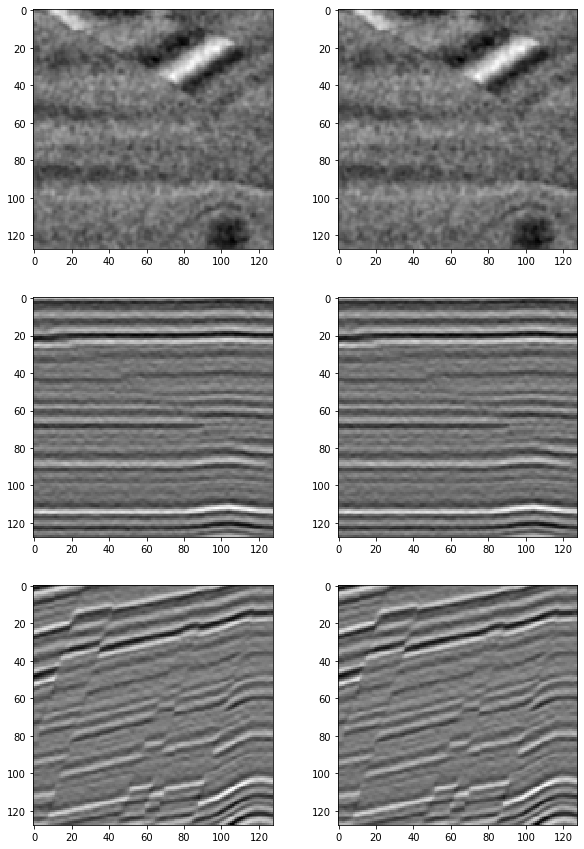

In [824]:
fig,axs = plt.subplots(3,2,figsize=(10,15))
ind = 100
wu = wu.reshape((128,128,128)).T

axs[0,0].imshow(wu[ind,:,:],'gray')
axs[0,1].imshow(wu[ind,:,:],cmap='gray')

axs[1,0].imshow(wu[:,ind,:],'gray')
axs[1,1].imshow(wu[:,ind,:],cmap='gray')

axs[2,0].imshow(wu[:,:,ind],'gray')
axs[2,1].imshow(wu[:,:,ind],cmap='gray')